In [1]:
from tenpy.models.lattice import Lattice
from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import SpinSite
from tenpy.tools.params import get_parameter
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
import numpy as np
import matplotlib.pyplot as plt
import time
import random

# Model Definition

In [2]:
#Create a ComplingMPOModel to describe the system.
#The parameters are passed via model_params
class Heisenberg(CouplingMPOModel):

    def __init__(self,model_params):
        CouplingMPOModel.__init__(self,model_params)
    
    def init_lattice(self, model_params):
        #Here initialize the type of lattice considered
        lattice = get_parameter(model_params, 'lattice', self.name, False)
        return lattice
        
    def init_terms(self, model_params):
        D= get_parameter(model_params, 'D', 0., self.name, True)
        J= get_parameter(model_params, 'J', 1., self.name, True)
        lam= get_parameter(model_params, 'lambda', 0., self.name, True)
        
        #Here implement the couplings of the chain
        
        #D term
        self.add_onsite(D, 0, 'Sz Sz')     
        
        #Heisenberg interaction
        self.add_coupling(J, 0, 'Sx', 0, 'Sx', 1,) 
        self.add_coupling(J, 0, 'Sy', 0, 'Sy', 1,)
        self.add_coupling(J, 0, 'Sz', 0, 'Sz', 1,)
        
        #Quadratic Heisenberg term
        for i in ['Sx','Sy','Sz']:
            for j in ['Sx','Sy','Sz']:
                names1=[i,j]
                names2=[i,j]
                op1=' '.join(names1)
                op2=' '.join(names2)
                self.add_coupling(lam, 0, op1, 0, op2, 1,)

# Phase diagram for $\lambda=0$ and varying $D$

## Define the model 

In [175]:
L=2 #Chain length (2 for the iMPS)
J=1 #Anitferromagnetic interaction
lam=0 #Quadratic term
Dmin=-1
Dmax=2
points=30
d=np.linspace(Dmin,Dmax,points,endpoint=True) #Values considered for D

#Definition of the lattice model
site=SpinSite(S=1, conserve=None)
lat=Lattice([L],[site],order='default',bc='periodic',bc_MPS='infinite') #We choose an infinite MPS  

## Perform iDMRG

In [176]:
entEnt=[]
entSp=[]
stagMag=[]
for D in d:
    
    #Define the paramters of the model
    model_params={
        'verbose':0,
        'J':J,
        'D':D,
        'lambda':lam, 
        'lattice':lat 
    }

    #Create the model
    chain=Heisenberg(model_params)

    #Define the paramters for the DMRG
    dmrg_paramsGs = {
        'mixer': False,
        'trunc_params': {
            'chi_max': 20, #Maximum bond dimension
            'svd_min': 1.e-12
        },
        'max_E_err': 1.e-12,
        'verbose': 0
    }
    
    #Initialize the MPS with an arbitrary product state
    product_state=['up',0]
    psiGs=MPS.from_product_state(chain.lat.mps_sites(),product_state,bc=chain.lat.bc_MPS)
    
    #Perform iDMRG
    info=dmrg.run(psiGs, chain, dmrg_paramsGs)
        
    mag=psiGs.expectation_value('Sz') #Measure Sz component at each site
    stagMag.append(abs(mag[0]-mag[1])/2) #Compute staggered magnetization
    
    spectrum=psiGs.entanglement_spectrum()
    entSp.append(spectrum[0])
    
    entropy=psiGs.entanglement_entropy() #Measure entanglement entropy
    entEnt.append(entropy[0])
    

## Study staggered magnetization

(-1, 2)

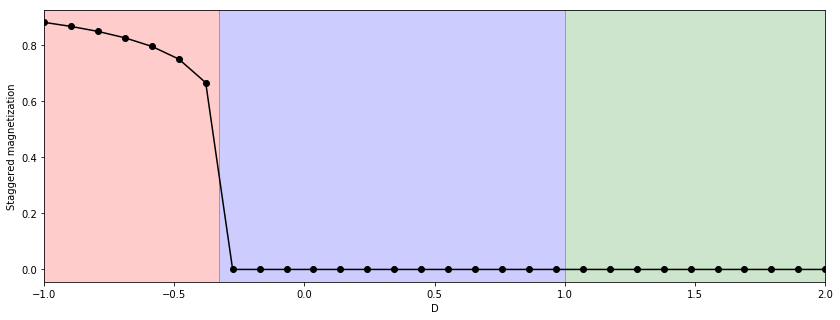

In [177]:
plt.figure(figsize=(14,5))
plt.plot(d,stagMag,'o',ls='-',c='k')
plt.xlabel('D');
plt.ylabel('Staggered magnetization');
plt.axvspan(-1, -0.33, alpha=0.2, color='red')
plt.axvspan(-0.33, 1, alpha=0.2, color='b')
plt.axvspan(1, 2, alpha=0.2, color='g')
plt.xlim(-1,2)

Staggered magnetization is an order parameter that describes long range order. It's value is different from 0 only for values of $D$ smaller than $D_{\text{AF}}\approx -0.33$. Below the critical value, the system has long range order and the ground state is ferromagnetic. For larger $D$, the staggered magnetization is zero and the system does not display long range order. According to Landau criterion this should be a single unique phase.

Note: a priori, before claiming that there is no long range order for $D>D_{\text{AF}}$ we should check other order parameters beyond the antiferromagnetic one. For the moment we will ignore this detail. 

## Study of the entanglement entropy

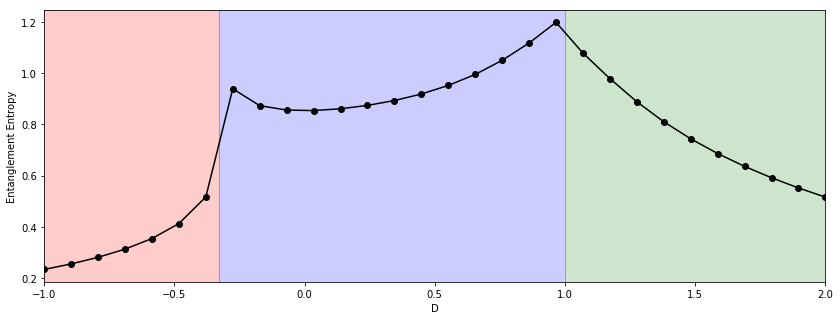

In [178]:
plt.figure(figsize=(14,5))
plt.tight_layout()
plt.plot(d,entEnt,'o',ls='-',c='k')
plt.xlabel('D');
plt.ylabel('Entanglement Entropy');
plt.axvspan(-1, -0.33, alpha=0.2, color='red')
plt.axvspan(-0.33, 1, alpha=0.2, color='b')
plt.axvspan(1, 2, alpha=0.2, color='g')
plt.xlim(-1,2);

In the lecture notes you have seen the definition of the entanglement entroby for a generic bipartition in two systems A and B: $$S=-\text{Tr}\rho_A\text{log}\rho_A=-\sum_\alpha\lambda_\alpha\text{log}\lambda_\alpha$$ where $\lambda_\alpha$ are the Schmidt values. A divergence in the entanglement entropy signals the presence of a phase transition. 

We again find the antiferromagnetic phase transtion at $D_\text{AF}$ but there now seems to be another transition that was not captured by the staggered magnetization. Such transtion occurs at $D_{\text{Hal}}=1$ and it is a topological phase transtion between two phases with the same symmetries but different topological properties. One phase is the Haldane phase for small $D$ and the other is a phase connected to $D\rightarrow\infty$, where the ground state is a product state of sites with zero magnetization.

## Study of the entanglement spectrum

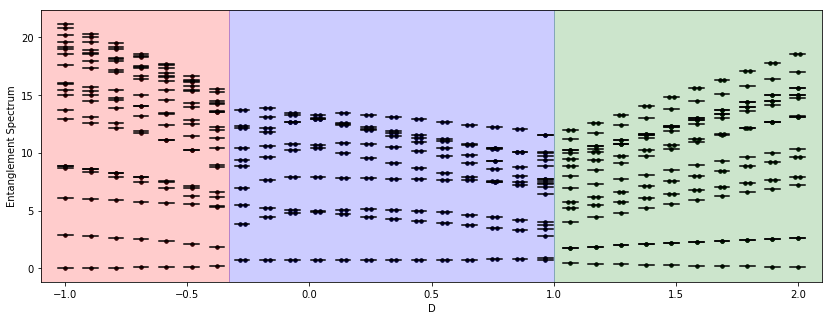

In [179]:
plt.figure(figsize=(14,5))
plt.tight_layout()

for i in range(len(d)): 
    for j in range(int(len(entSp[i])/2)):
        if abs(entSp[i][2*j]-entSp[i][2*j+1])<1e-4:
            plt.scatter(d[i]-0.01,entSp[i][2*j],c='k',s=50,marker='.')
            plt.scatter(d[i]+0.01,entSp[i][2*j+1],c='k',s=50,marker='.')
            plt.plot([d[i]-0.03,d[i]+0.03],[entSp[i][2*j],entSp[i][2*j]],c='k')
        else:
            plt.scatter(d[i],entSp[i][2*j],c='k',s=50,marker='.')
            plt.scatter(d[i],entSp[i][2*j+1],c='k',s=50,marker='.')
            plt.plot([d[i]-0.03,d[i]+0.03],[entSp[i][2*j],entSp[i][2*j]],c='k')
            plt.plot([d[i]-0.03,d[i]+0.03],[entSp[i][2*j+1],entSp[i][2*j+1]],c='k')
        
plt.xlabel('D');
plt.ylabel('Entanglement Spectrum');
plt.axvspan(-1.1, -0.33, alpha=0.2, color='red')
plt.axvspan(-0.33, 1, alpha=0.2, color='b')
plt.axvspan(1, 2.1, alpha=0.2, color='g')
plt.xlim(-1.1,2.1);

The entanglement spectrum allows us to distinguish between topological and trivial phases. In fact, in a symmetry protected topological phase the entanglement spectrum is always doubly degenerate. In the plot each line shows a level of the entanglement spectrum and the number of dots represents its degeneracy, We therefore found that the phase $D\in [-0.33,1]$ is topological, while the other two phases are topologically trivial. This topological phase is the famous Haldane phase.

# Phase diagram for $D=0$ and varying $\lambda$ 

## Define the model 

In [3]:
L=2 #Chain length (2 for the iMPS)
J=1 #Anitferromagnetic interaction
D=0
lammin=0
lammax=1/3
points=30
ll=np.linspace(lammin,lammax,points,endpoint=True) #Values considered for D

#Definition of the lattice model
site=SpinSite(S=1, conserve=None)
lat=Lattice([L],[site],order='default',bc='periodic',bc_MPS='infinite') #We choose an infinite MPS  

## Perform iDMRG

In [4]:
entEnt=[]
entSp=[]
stagMag=[]
for lam in ll:
    
    #Define the paramters of the model
    model_params={
        'verbose':0,
        'J':J,
        'D':D,
        'lambda':lam, 
        'lattice':lat 
    }

    #Create the model
    chain=Heisenberg(model_params)

    #Define the paramters for the DMRG
    dmrg_paramsGs = {
        'mixer': False,
        'trunc_params': {
            'chi_max': 30, #Maximum bond dimension
            'svd_min': 1.e-12
        },
        'max_E_err': 1.e-12,
        'verbose': 0
    }
    
    #Initialize the MPS with an arbitrary product state
    product_state=['up','down']
    psiGs=MPS.from_product_state(chain.lat.mps_sites(),product_state,bc=chain.lat.bc_MPS)
    
    #Perform iDMRG
    info=dmrg.run(psiGs, chain, dmrg_paramsGs)
        
    mag=psiGs.expectation_value('Sz') #Measure Sz component at each site
    stagMag.append(abs(mag[0]-mag[1])/2) #Compute staggered magnetization
    
    spectrum=psiGs.entanglement_spectrum()
    entSp.append(spectrum[0])
    
    entropy=psiGs.entanglement_entropy() #Measure entanglement entropy
    entEnt.append(entropy[0])
    

## Study staggered magnetization

(-0.1, 0.25)

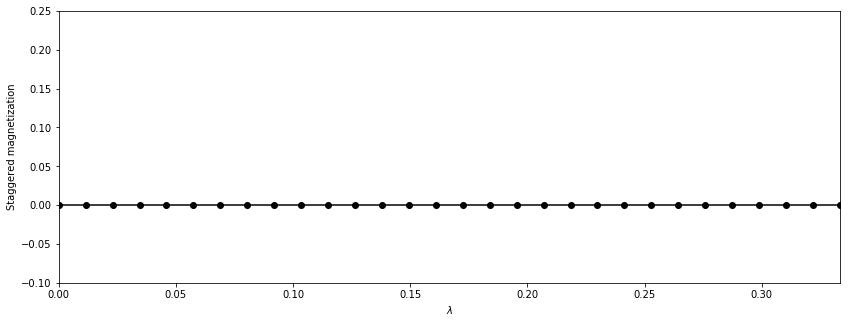

In [5]:
plt.figure(figsize=(14,5))
plt.plot(ll,stagMag,'o',ls='-',c='k')
plt.xlabel('$\lambda$');
plt.ylabel('Staggered magnetization');
plt.xlim(0,1/3)
plt.ylim(-0.1,0.25)

## Study of the entanglement entropy

(0.5, 0.9)

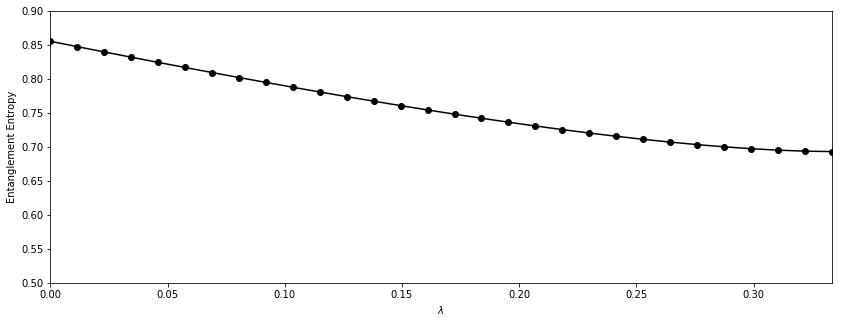

In [6]:
plt.figure(figsize=(14,5))
plt.tight_layout()
plt.plot(ll,entEnt,'o',ls='-',c='k')
plt.xlabel('$\lambda$');
plt.ylabel('Entanglement Entropy');
plt.xlim(0,1/3);
plt.ylim(0.5,0.9)

## Study of the entanglement spectrum

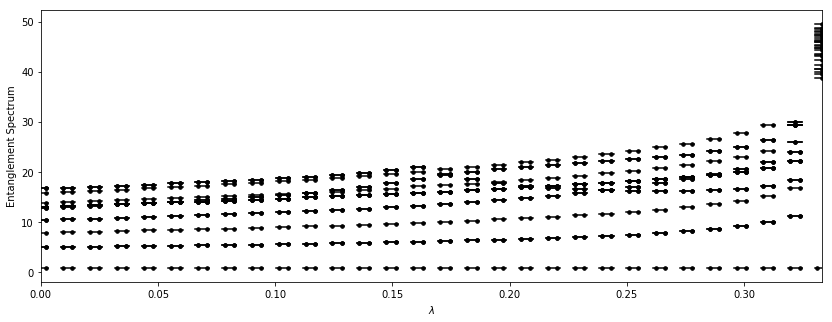

In [7]:
plt.figure(figsize=(14,5))
plt.tight_layout()

for i in range(len(ll)): 
    for j in range(int(len(entSp[i])/2)):
        if abs(entSp[i][2*j]-entSp[i][2*j+1])<1e-3:
            plt.scatter(ll[i]-0.002,entSp[i][2*j],c='k',s=50,marker='.')
            plt.scatter(ll[i]+0.002,entSp[i][2*j+1],c='k',s=50,marker='.')
            plt.plot([ll[i]-0.003,ll[i]+0.003],[entSp[i][2*j],entSp[i][2*j]],c='k')
        else:
            plt.scatter(ll[i],entSp[i][2*j],c='k',s=50,marker='.')
            plt.scatter(ll[i],entSp[i][2*j+1],c='k',s=50,marker='.')
            plt.plot([ll[i]-0.003,ll[i]+0.003],[entSp[i][2*j],entSp[i][2*j]],c='k')
            plt.plot([ll[i]-0.003,ll[i]+0.003],[entSp[i][2*j+1],entSp[i][2*j+1]],c='k')
        
plt.xlabel('$\lambda$');
plt.ylabel('Entanglement Spectrum');
plt.xlim(0,1/3);